### Exercise 1: Customer Segmentation Using KMeans Clustering

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits import mplot3d

#### 1. Load the Dataset
##### Load the Mall Customers dataset and print first 5 rows.

In [2]:
df = pd.read_csv("dataset/mall_customers.csv")

##### Print the first 5 rows of the dataset to get the overview of dataframe.

In [3]:
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 2. Perform Basic Preprocessing

##### As the column names are quite complex, we can change them to a simpler name so we can access our data easier.

In [4]:
df = df.rename(columns={'Annual Income (k$)': 'Annual Income', 'Spending Score (1-100)': 'Spending Score'})

##### Get statistically description of the numerical data in the dataframe.

In [5]:
df.describe()

,CustomerID,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


##### Use scatter plot to visually inspect the distribution.

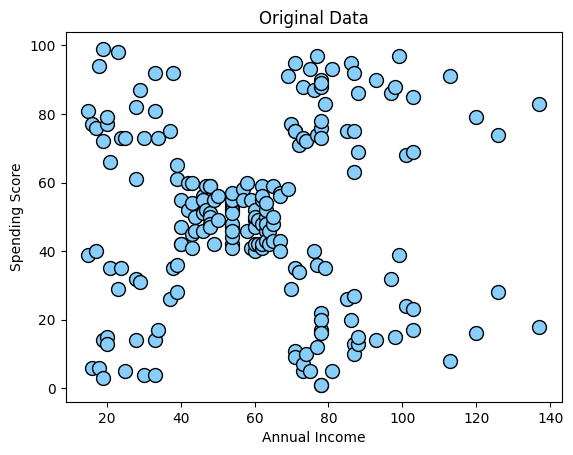

In [6]:
plt.scatter(df['Annual Income'], df['Spending Score'], c='lightskyblue', edgecolors='k', s=100)
plt.title("Original Data")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

##### Calculate IQR for Annual Income and Spending Score.

In [7]:
Q1 = df[['Annual Income', 'Spending Score']].quantile(0.25)
Q3 = df[['Annual Income', 'Spending Score']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

##### The data points that are far from the majority of the data can be considered outliers and removed.

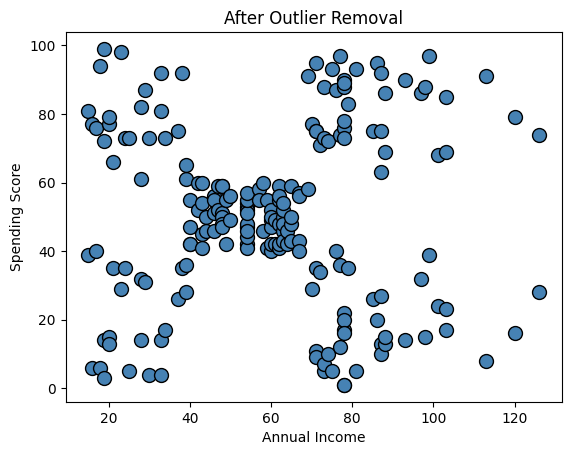

In [8]:
df = df[(df['Annual Income'] >= lower_bound['Annual Income']) & (df['Annual Income'] <= upper_bound['Annual Income']) &
        (df['Spending Score'] >= lower_bound['Spending Score']) & (df['Spending Score'] <= upper_bound['Spending Score'])]
plt.scatter(df['Annual Income'], df['Spending Score'], c='steelblue', edgecolors='k', s=100)
plt.title("After Outlier Removal")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

##### Drop the CustomerID Column as it is of no use.

In [9]:
df.drop(['CustomerID'], axis=1, inplace=True)

#### 3. Analyze Correlation and Feature Selection

In [10]:
features = ['Gender', 'Age', 'Spending Score']

##### Converte Gender to binary column (0 for Male, 1 for Female).

In [11]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [12]:
corr_matrix = df[features].corr()

##### Create heatmap on correlation matrix, set colormap to cmap.

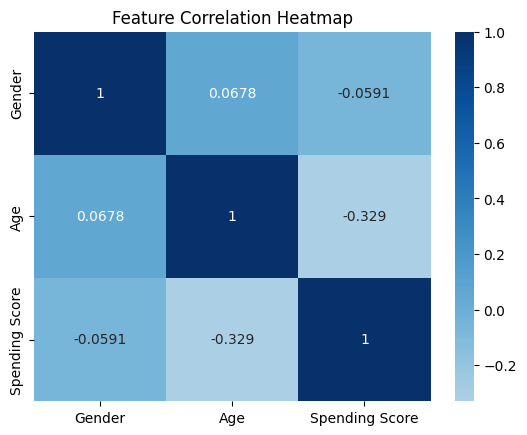

In [13]:
sns.heatmap(corr_matrix, annot=True, center=0, cmap="Blues", robust=True, fmt='.3g')
plt.title("Feature Correlation Heatmap")
plt.show()

##### There is a moderate negative relationship between Age and Spending Score. This means Age has some influence, but it's not the most significant factor when it comes to spending behavior. From the clustering process we want to exclude Gender because it has a very weak correlation with Spend Score.


In [14]:
df.drop(['Gender'], axis=1, inplace=True)

#### 4. Use KMeans for Clustering

##### Create function to fit KMeans clustering and a scatter plot with cluster memberships for each item in the data. Add cluster centroids to the plot.

In [15]:
def fit_kmeans(K, data, method='k-means++', number=10, max_iters=300):
    kmeans = KMeans(
        n_clusters=K,
        init=method,
        n_init=number,
        max_iter=max_iters,
        tol=1e-4,
        random_state=0
    )
    kmeans.fit(data)
    return kmeans

def plot_kmeans(K, X, kmeans):
    y_kmeans = kmeans.predict(X)
    for k in range(K):
        plt.scatter(X[y_kmeans == k, 0], X[y_kmeans == k, 1], edgecolors='k', s=100, label="Cluster " + str(k + 1))
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', edgecolors='k', s=100, label='Centroids')
    plt.title("KMeans Clustering Scatter Plot")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()

##### Keep just the Annual Income and Spending score columns.

In [16]:
X = df[['Annual Income', 'Spending Score']]

##### Scaling is essential for this clustering process because Annual Income and Spending Score have different ranges. Clustering without scaling may give more weight to the variable with the larger range.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### Call apply_KMeans() function to apply KMeans clustering. Explore a range of values up to K=n (where n could be 6), because there is no clear indication of the ideal number of clusters.

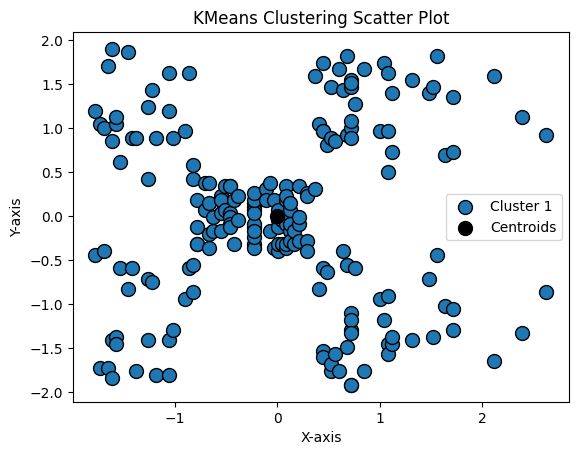

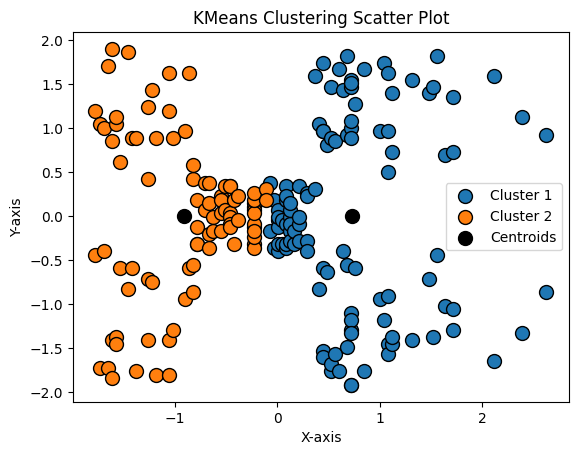

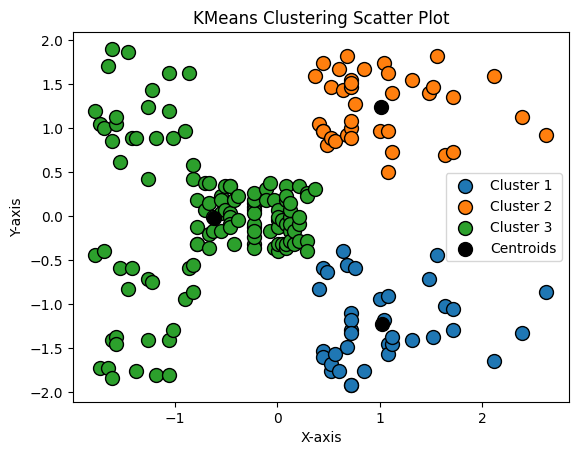

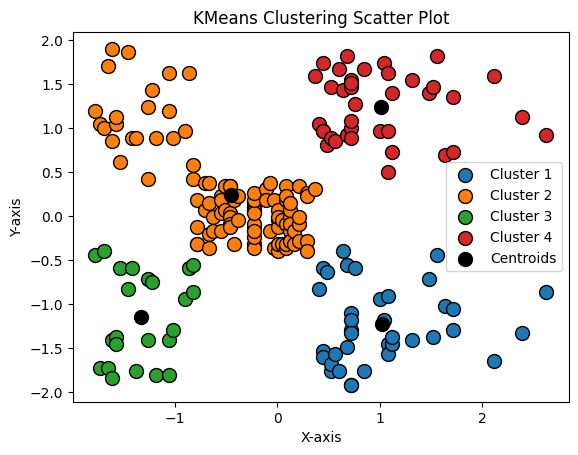

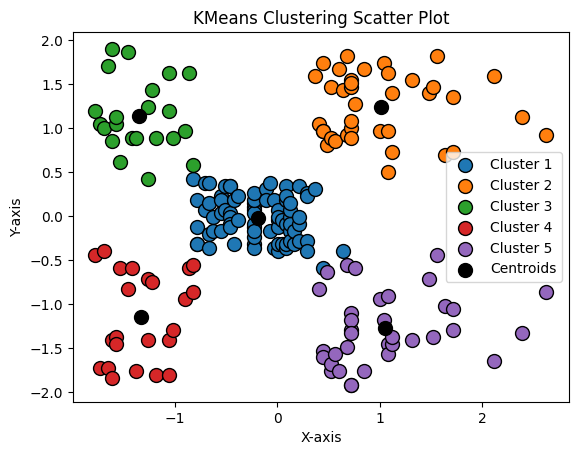

In [18]:
for k in range(1, 6):
    kmeans = fit_kmeans(k, X_scaled)
    plot_kmeans(k, X_scaled, kmeans)

#### 5. Evaluate kappa Using Both Methods

##### Compute KMeans for each k and store inertia.

In [19]:
inertia_values = []
k_values = range(1,20)
for k in k_values:
    kmeans = fit_kmeans(k, X_scaled)
    inertia_values.append(kmeans.inertia_)

##### Plot the elbow curve.

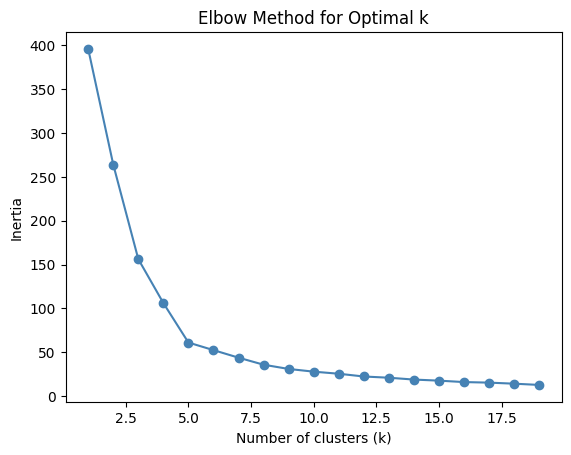

In [20]:
plt.plot(k_values , inertia_values , marker='o', color="steelblue")
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

##### Compute KMeans for each k and store silhouette score.

In [21]:
silhouette_scores = []
k_values = range(2,20)
for k in k_values:
    kmeans = fit_kmeans(k, X_scaled)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

##### Plot Silhouette Scores.

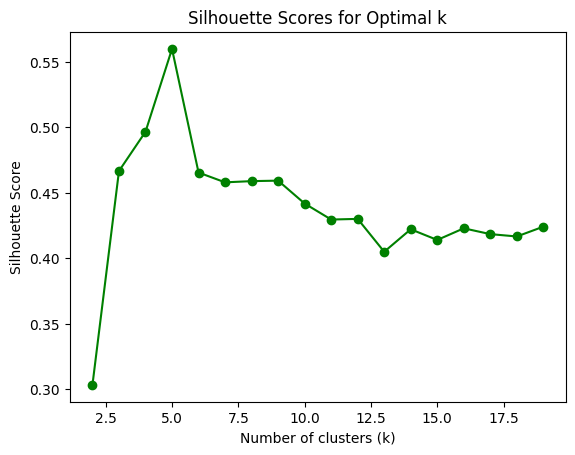

In [22]:
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

##### In the Elbow method above, we can say that 5 will be our cluster number. The Silhouette score for k = 5 also shows a high value. Even if the Elbow method may be lower than the Silhouette score, the grouping is actually better with 5 groups.

#### 6. Tune the KMeans Algorithm

##### Adjust parameters init, n_init, and max_iter to improve the performance of the KMeans clustering algorithm. We keep k-means++ for better results and set n_init to a higher value like 30 to improve the reliability of our results. We can increase the maximum number of iterations to 500 for more iterations.

In [23]:
optimal_k = 5
kmeans = fit_kmeans(optimal_k, X_scaled, 'k-means++', 30, 500)

#### 7. Plot the Clusters

##### Using features Annual Income and Spending Score plot 2D view of K-Means 5 clusters

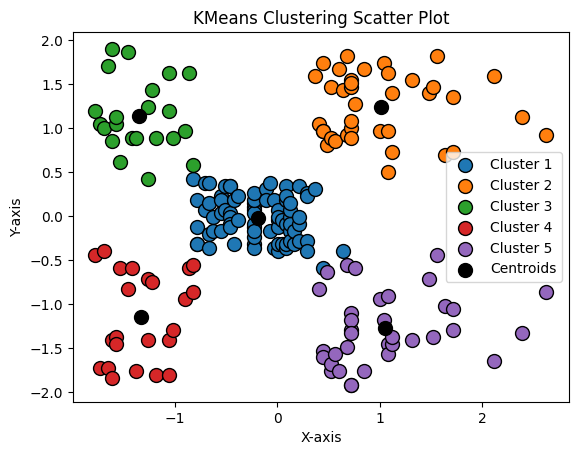

In [24]:
plot_kmeans(optimal_k, X_scaled, kmeans)

##### Using features Age, Annual Income and Spending Score plot 3D view of K-Means 5 clusters

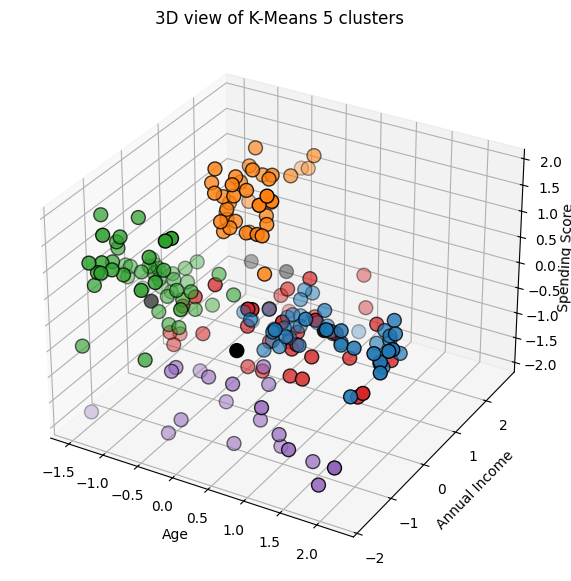

In [25]:
X = df[['Age', 'Annual Income', 'Spending Score']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = fit_kmeans(optimal_k, X_scaled, 'k-means++', 30, 500)
y_kmeans = kmeans.predict(X_scaled)

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection ='3d')
for k in range(optimal_k):
    ax.scatter(X_scaled[y_kmeans == k, 0], X_scaled[y_kmeans == k, 1], X_scaled[y_kmeans == k, 2], edgecolors='k', s=100, label="Cluster " + str(k + 1))
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', edgecolors='k', s=100, label='Centroids')
ax.set_title('3D view of K-Means 5 clusters')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score', labelpad=0)
plt.show()

#### 8. Identify High-Spending Clusters

##### From the above graphs, cluster 1 and cluster 3 are the high-spending clusters.

In [26]:
df['Cluster'] = y_kmeans
high_spending_df = df[df['Cluster'].isin([1, 3])]

##### From the below statistically description, we can see that the average Age in these high-spending clusters is lower than the overall average age. Most of customers in these clusters is between 30 and 40. These two high-spending clusters have incomes ranging from 64.000 to 126.000, with mean incomes of ~ 84K, indicating that the high-spending customers have higher incomes. The original dataset includes customers with much lower incomes down to 15K.

In [27]:
high_spending_df.describe()

,Age,Annual Income,Spending Score,Cluster
count,77.000000,77.000000,77.000000,77.000000
mean,36.467532,84.779221,50.844156,1.987013
std,8.909759,14.384406,33.091605,1.006473
min,19.000000,64.000000,1.000000,1.000000
25%,31.000000,74.000000,17.000000,1.000000
50%,35.000000,78.000000,58.000000,1.000000
75%,41.000000,93.000000,83.000000,3.000000
max,59.000000,126.000000,97.000000,3.000000


##### Customers with higher annual incomes have more disposable income and are likely able to make discretionary purchases. The marketing team can consider providing premium products to the higher spending scores customers.